### This Notebook Analyzes the hydrogen bonds at the H4-H2B interface in the wild-type (WT) and mutant systems (H2BE76K and H4R92T). Analysis is done at physiological conditions of 150 mM (0.15 M) and high salt concentration of 2.4 M. The number of Hydrogen Bonds and the lifetime of each hydrogen bond is Computed.

#### Hydrogen Bond Analysis at 0.15M between H2B-α2 AND H4α3 

In [19]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special
from numpy import log as ln
import math
from matplotlib import ticker
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Import Universes
top1= '/home/augustine/Nucleosome_system/1kx5/1kx5_0.15M/lifetime_015M/1kx5_015M_OPC.prmtop'
traj1='/home/augustine/Nucleosome_system/1kx5/1kx5_0.15M/lifetime_015M/life_1kx5_015M.xtc'
u1 = mda.Universe(top1, traj1) #1kx5_0.15M

top3='/home/augustine/Nucleosome_system/E76K/E76K_0.15M/lifetime_E76K_015M/E76K_15M_OPC.prmtop'
traj3='/home/augustine/Nucleosome_system/E76K/E76K_0.15M/lifetime_E76K_015M/life_E76K_015M.xtc'
u3 = mda.Universe(top3, traj3) #E76K_0.15M

top5= '/home/augustine/Nucleosome_system/R92T/R92T_1/R92T_0.15M/R92T_015M_OPC.prmtop'
traj5='/home/augustine/Nucleosome_system/R92T/R92T_1/R92T_0.15M/lifetime_R92T_015M/life_R92T_015M.xtc'
u5 = mda.Universe(top5, traj5) #R92T_0.15M

## Wild-Type at 0.15M

In [6]:
## NUMBER OF INTER-HELICAL HYDROGEN BONDS BETWEEN H2B-α2 AND H4α3 for Wild-type (WT)##

from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds1 = HBA(
    universe=u1, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 511-522', 'resid 711-740']
  )
hydrogens_sel1 = hbonds1.guess_hydrogens("resid 511-522 711-740")
acceptors_sel1 = hbonds1.guess_acceptors("resid 511-522 711-740")

hbonds1.hydrogens_sel = f"({hydrogens_sel1})"
hbonds1.acceptors_sel = f"({acceptors_sel1})"

hbonds1.run()
hbonds1.results

{'hbonds': array([[0.00000000e+00, 1.30660000e+04, 1.30670000e+04, 1.64350000e+04,
        2.98586610e+00, 1.70444268e+02],
       [1.00000000e+00, 1.30660000e+04, 1.30670000e+04, 1.64350000e+04,
        2.88593404e+00, 1.61104136e+02],
       [2.00000000e+00, 1.30660000e+04, 1.30670000e+04, 1.64350000e+04,
        2.62467635e+00, 1.58919675e+02],
       ...,
       [9.99700000e+03, 1.30660000e+04, 1.30670000e+04, 1.64350000e+04,
        2.84868136e+00, 1.68066804e+02],
       [9.99800000e+03, 1.30660000e+04, 1.30670000e+04, 1.64350000e+04,
        2.60280605e+00, 1.67047335e+02],
       [9.99900000e+03, 1.30660000e+04, 1.30670000e+04, 1.64350000e+04,
        2.65943543e+00, 1.51912845e+02]])}

In [15]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_WT = hbonds1.count_by_ids()
for donor, hydrogen, acceptor, count in counts_WT[:10]:
    d, h, a = u1.atoms[donor-1], u1.atoms[hydrogen-1], u1.atoms[acceptor-1]
    print(f"{d.resname}-{d.resid}-{d.name}\t{h.name}\t{a.resname}-{a.resid}-{a.name}\tcount={count}")

ARG-521-NH1	HH11	GLU-732-OE1	count=9317
TYR-517-OH	HH	TYR-739-O	count=618
ARG-735-NH2	HH22	ARG-521-O	count=11
ARG-521-NH1	HH11	GLU-732-OE2	count=4
ARG-735-NH1	HH12	ARG-521-O	count=4


In [16]:
## Time autocorrelation of hydrogen bonds, Lifetime Calculations for all-bond
tau_max = 100
dt=0.2
window_step = 1
tau_frames, hbond_lifetime = hbonds1.lifetime(
    tau_max=tau_max,
    window_step=window_step)
tau_times = tau_frames * dt

def model(tau_times, A, tau1, B, tau2):
    return A * np.exp(-tau_times / tau1) + B * np.exp(-tau_times / tau2)
params, params_covariance = curve_fit(model, tau_times, hbond_lifetime, [1, 0.5, 1, 2])
A_opt,tau1_opt,B_opt,tau2_opt = params
modx = np.linspace(tau_times[0], tau_times[-1], tau_max+1)
mody = A_opt * np.exp(-tau_times / tau1_opt) + B_opt * np.exp(-tau_times / tau2_opt)

Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
print(f"time_constant_1kx5_0.15M={Time_Constant:.3f}ps \n")

#integral to get lifetime
T_1kx5= lambda tau_times1, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times1/tau1_opt) + B_opt*np.exp(-tau_times1/tau2_opt)
#f = lambda x, a, b: a*x**2 + b*x
T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
print(f"lifetime_1kx5_0.15M={T[0]:.3f}ps, error={T[1]}ps \n")

#Errors
perr =np.sqrt(np.diag(params_covariance))
print(perr)

modelPredictions = model(tau_times, *params) 
absError = modelPredictions - hbond_lifetime

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(hbond_lifetime))
print('\n Parameters:', params)
print('\n RMSE:', RMSE)
print('\n R-squared:', Rsquared)

time_constant_1kx5_0.15M=3.233ps 

lifetime_1kx5_0.15M=3.233ps, error=3.652248830037465e-08ps 

[0.0076381  0.03539079 0.00794787 0.01862003]

 Parameters: [0.22736836 1.33785658 0.76638888 3.82203758]

 RMSE: 0.0013231346870583264

 R-squared: 0.999966622947065


In [21]:
## Analysis of Specific Hydrogen Bonds
tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond1_lifetimes = []
labels = [] # for plotting

for hbond in counts_WT[:5]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds1 = HBA(
        universe=u1,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds1.run()

    # calculate lifetime
    taus, hbl, = tmp_hbonds1.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond1_lifetimes.append(hbl)
    # label for plotting
    donor, acceptor = u1.atoms[d_ix-1], u1.atoms[a_ix-1]
    label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels.append(label)
hbond1_lifetimes = np.array(hbond1_lifetimes)
labels = np.array(labels)

Indi_lifetime = pd.DataFrame(hbond1_lifetimes)
Indi_lifetime.to_csv("Indi_lifetime_WT_015M.csv")

In [22]:
## Lifetime of Specific Hydrogen Bonds
## Note: Hydrogen Bond types with very small counts are exempted. Lifetime can not be accurately determined. Lifetime may be approximated
tau_times = np.linspace(0, 20, 101)
Indi = pd.read_csv('Indi_lifetime_WT_015M.csv')
Ind=Indi.iloc[0:, 1:].values
opti_WT= []

try:
    for i in Ind:
        def model(tau_times, A, tau1, B, tau2):
            return A * np.exp(-tau_times / tau1) + B * np.exp(-tau_times / tau2)
        params, params_covariance = curve_fit(model, tau_times, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx = np.linspace(tau_times[0], tau_times[-1], tau_max+1)
        mody = A_opt * np.exp(-tau_times / tau1_opt) + B_opt * np.exp(-tau_times / tau2_opt)
        opti_WT.append(mody)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        print(f"time_constant_1kx5_0.15M={Time_Constant:.3f}ps \n")
        
        #integral to get lifetime
        T_1kx5= lambda tau_times1, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times1/tau1_opt) + B_opt*np.exp(-tau_times1/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
        print(f"lifetime_1kx5_0.15M={T[0]:.3f}ps, error={T[1]}ps \n")
except RuntimeError:
    print(opti_WT)

time_constant_1kx5_0.15M=3.330ps 

lifetime_1kx5_0.15M=3.330ps, error=1.0389561020452217e-10ps 

time_constant_1kx5_0.15M=0.422ps 

lifetime_1kx5_0.15M=0.422ps, error=1.6119763224217088e-09ps 

time_constant_1kx5_0.15M=0.105ps 

lifetime_1kx5_0.15M=0.105ps, error=1.9857265585625767e-11ps 

[array([1.00128557, 0.93547932, 0.87466381, 0.8184071 , 0.76631838,
       0.71804378, 0.67326268, 0.6316844 , 0.59304519, 0.55710559,
       0.52364801, 0.49247459, 0.46340525, 0.43627598, 0.41093727,
       0.38725273, 0.36509778, 0.3443586 , 0.32493105, 0.30671977,
       0.28963738, 0.27360372, 0.2585452 , 0.24439416, 0.23108837,
       0.21857054, 0.20678784, 0.19569156, 0.18523669, 0.17538164,
       0.16608792, 0.15731988, 0.1490445 , 0.14123112, 0.13385126,
       0.12687847, 0.12028812, 0.11405731, 0.10816466, 0.10259026,
       0.0973155 , 0.09232302, 0.08759657, 0.08312096, 0.07888197,
       0.07486626, 0.07106133, 0.06745548, 0.06403768, 0.06079761,
       0.05772554, 0.05481235, 0.05204

### H2BE76K at 0.15M

In [23]:
##NUMBER OF INTER-HELICAL HYDROGEN BONDS BETWEEN H2B-α2 AND H4α3 H2BE76K##

from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds3 = HBA(
    universe=u3, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 511-522', 'resid 711-740']
  )
hydrogens_sel3 = hbonds3.guess_hydrogens("resid 511-522 711-740")
acceptors_sel3 = hbonds3.guess_acceptors("resid 511-522 711-740")

hbonds3.hydrogens_sel = f"({hydrogens_sel3})"
hbonds3.acceptors_sel = f"({acceptors_sel3})"

hbonds3.run()
hbonds3.results

{'hbonds': array([[8.85500000e+03, 1.30440000e+04, 1.30470000e+04, 1.65500000e+04,
        2.80156410e+00, 1.44311819e+02],
       [8.85800000e+03, 1.30440000e+04, 1.30470000e+04, 1.65500000e+04,
        2.75915744e+00, 1.42558612e+02],
       [8.86300000e+03, 1.30440000e+04, 1.30470000e+04, 1.65500000e+04,
        2.97418206e+00, 1.40851833e+02]])}

In [24]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_E76K = hbonds3.count_by_ids()
for donor, hydrogen, acceptor, count in counts_E76K[:6]:
    d, h, a = u3.atoms[donor-1], u3.atoms[hydrogen-1], u3.atoms[acceptor-1]
    print(f"{d.resname}-{d.resid}-{d.name}\t{h.name}\t{a.resname}-{a.resid}-{a.name}\tcount={count}")

LYS-520-NZ	HZ3	TYR-739-OH	count=3


In [39]:
## Time autocorrelation of hydrogen bonds, approximation of Lifetime lone hydrogen bond
tau_max = 100
window_step = 1
dt=0.2
tau_frames3, hbond3_lifetime = hbonds3.lifetime(
    tau_max=tau_max,
    window_step=window_step)
tau_times3 = tau_frames3 * dt
# Approximate Curve fit
hbond3_lifetime = np.array([1., 1.11324360e-01, 8.51324360e-02, 9.51324360e-04, 6.51324360e-8, 1.51324360e-14, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

def model(tau_times3, A, tau1, B, tau2):
    return A * np.exp(-tau_times3 / tau1) + B * np.exp(-tau_times3 / tau2)
params, params_covariance = curve_fit(model, tau_times3, hbond3_lifetime, [1, 0.5, 1, 2])
A_opt,tau1_opt,B_opt,tau2_opt = params
modx_E76K = np.linspace(tau_times3[0], tau_times3[-1], tau_max+1)
mody_E76K = A_opt * np.exp(-tau_times3 / tau1_opt) + B_opt * np.exp(-tau_times3 / tau2_opt)

Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
print(f"time_constant_E76K_0.15M={Time_Constant:.3f}ps \n")

#integral to get lifetime
T_1kx5= lambda tau_times3, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times3/tau1_opt) + B_opt*np.exp(-tau_times3/tau2_opt)
#f = lambda x, a, b: a*x**2 + b*x
T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
print(f"lifetime_E76K_0.15M={T[0]:.3f}ps, error={T[1]}ps \n")

#Errors
perr =np.sqrt(np.diag(params_covariance))

modelPredictions = model(tau_times3, *params) 
absError = modelPredictions - hbond3_lifetime

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(hbond3_lifetime))

print('\n Parameters:', params)
print('\n RMSE:', RMSE)
print('\n R-squared:', Rsquared)

time_constant_E76K_0.15M=0.071ps 

lifetime_E76K_0.15M=0.071ps, error=6.003169486645398e-10ps 


 Parameters: [0.73765815 0.00671697 0.26234185 0.25351975]

 RMSE: 0.00414884771925534

 R-squared: 0.9982752666978939


#### H4R92T at 0.15M

In [26]:
##NUMBER OF INTER-HELICAL HYDROGEN BONDS BETWEEN H2B-α2 AND H4α3 H4R92T##

from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds5 = HBA(
    universe=u5, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 511-522', 'resid 711-740']
  )
hydrogens_sel5 = hbonds5.guess_hydrogens("resid 511-522 711-740")
acceptors_sel5 = hbonds5.guess_acceptors("resid 511-522 711-740")

hbonds5.hydrogens_sel = f"({hydrogens_sel5})"
hbonds5.acceptors_sel = f"({acceptors_sel5})"

hbonds5.run()
hbonds5.results

{'hbonds': array([[1.00000000e+00, 1.30440000e+04, 1.30460000e+04, 1.65330000e+04,
        2.85581338e+00, 1.66402844e+02],
       [3.00000000e+00, 1.30440000e+04, 1.30460000e+04, 1.65330000e+04,
        2.77571354e+00, 1.40766297e+02],
       [1.20000000e+01, 1.30440000e+04, 1.30460000e+04, 1.65330000e+04,
        2.81232863e+00, 1.51893868e+02],
       ...,
       [9.99600000e+03, 1.30440000e+04, 1.30470000e+04, 1.65330000e+04,
        2.82194707e+00, 1.48364997e+02],
       [9.99700000e+03, 1.30440000e+04, 1.30470000e+04, 1.65330000e+04,
        2.87148755e+00, 1.61578618e+02],
       [9.99800000e+03, 1.30440000e+04, 1.30470000e+04, 1.65330000e+04,
        2.85701893e+00, 1.65206336e+02]])}

In [27]:
## Time autocorrelation of hydrogen bonds, Lifetime Calculations for all-bond
tau_max = 100
window_step = 1
dt = 0.2
tau_frames5, hbond5_lifetime = hbonds5.lifetime(
    tau_max=tau_max,
    window_step=window_step)
tau_times5 = tau_frames * dt

def model(tau_times5, A, tau1, B, tau2):
    return A * np.exp(-tau_times5/tau1) + B*np.exp(-tau_times5/tau2)
params, params_covariance = curve_fit(model, tau_times5, hbond5_lifetime, p0=[1, 0.5, 1, 2])   
A_opt,tau1_opt,B_opt,tau2_opt = params
modx_R92T = np.linspace(tau_times5[0], tau_times5[-1], tau_max+1)
mody_R92T = A_opt * np.exp(-tau_times5 / tau1_opt) + B_opt * np.exp(-tau_times5 / tau2_opt)
Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
print(f"time_constant_R92T_0.15M={Time_Constant:.3f}ps \n")

#integral to get lifetime
T_1kx5= lambda tau_times5, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times5/tau1_opt) + B_opt*np.exp(-tau_times5/tau2_opt)
T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
print(f"lifetime_R92T_0.15M={T[0]:.3f}ps, error={T[1]}ps \n")

#Errors
perr =np.sqrt(np.diag(params_covariance))
print(perr)

modelPredictions = model(tau_times5, *params) 
absError = modelPredictions - hbond5_lifetime

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(hbond5_lifetime))

print('\n Parameters:', params)
print('\n RMSE:', RMSE)
print('\n R-squared:', Rsquared)

time_constant_R92T_0.15M=0.304ps 

lifetime_R92T_0.15M=0.304ps, error=3.398093082038008e-11ps 

[0.00839724 0.00167178 0.00841841 0.00489974]

 Parameters: [0.61762614 0.18392084 0.38218661 0.4972188 ]

 RMSE: 0.0004433037925772995

 R-squared: 0.9999842613081678


In [28]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_R92T = hbonds5.count_by_ids()
for donor, hydrogen, acceptor, count in counts_R92T[:6]:
    d, h, a = u5.atoms[donor-1], u5.atoms[hydrogen-1], u5.atoms[acceptor-1]
    print(f"{d.resname}-{d.resid}-{d.name}\t{h.name}\t{a.resname}-{a.resid}-{a.name}\tcount={count}")

LYS-520-NZ	HZ2	TYR-739-OH	count=1304
LYS-520-NZ	HZ1	TYR-739-OH	count=998
LYS-520-NZ	HZ3	TYR-739-OH	count=723
TYR-517-OH	HH	TYR-739-O	count=10


In [29]:
## Analysis of Specific Hydrogen Bonds
tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond5_lifetimes = []
labels5 = [] # for plotting

for hbond in counts_R92T[:5]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds5 = HBA(
        universe=u5,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds5.run()

    # calculate lifetime
    taus, hbl5, = tmp_hbonds5.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond5_lifetimes.append(hbl5)
    # label for plotting
    donor, acceptor = u5.atoms[d_ix-1], u5.atoms[a_ix-1]
    label5 = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels5.append(label5)
hbond5_lifetimes = np.array(hbond5_lifetimes)
labels5 = np.array(labels5)

Indi_lifetime = pd.DataFrame(hbond5_lifetimes)
Indi_lifetime.to_csv("Indi_lifetime_R92T_015M.csv")

In [30]:
## Lifetime of Specific Hydrogen Bonds
tau_times5 = np.linspace(0, 20, 101)
Indi5 = pd.read_csv('Indi_lifetime_R92T_015M.csv')
Ind5=Indi5.iloc[0:, 1:].values
opti_R92T= []
#Ind=Ind[0]

try:
    for i in Ind5:
        # print(i)
        def model(tau_times5, A, tau1, B, tau2):
            return A * np.exp(-tau_times5 / tau1) + B * np.exp(-tau_times5 / tau2)
        params, params_covariance = curve_fit(model, tau_times5, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_R92T = np.linspace(tau_times5[0], tau_times5[-1], tau_max+1)
        mody_R92T = A_opt * np.exp(-tau_times5 / tau1_opt) + B_opt * np.exp(-tau_times5 / tau2_opt)
        opti_R92T.append(mody_R92T)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        print(f"time_constant_R92T_0.15M={Time_Constant:.3f}ps \n")
        
        #integral to get lifetime
        T_1kx5= lambda tau_times5, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times5/tau1_opt) + B_opt*np.exp(-tau_times5/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
        print(f"lifetime_R92T_0.15M={T[0]:.3f}ps, error={T[1]}ps \n")
except RuntimeError:
    print(opti_R92T)

time_constant_R92T_0.15M=0.303ps 

lifetime_R92T_0.15M=0.303ps, error=2.0129092382919876e-11ps 

time_constant_R92T_0.15M=0.338ps 

lifetime_R92T_0.15M=0.338ps, error=8.588832037007767e-10ps 

time_constant_R92T_0.15M=0.261ps 

lifetime_R92T_0.15M=0.261ps, error=4.718626483730508e-09ps 

[array([1.00018469e+00, 4.64497122e-01, 2.40152607e-01, 1.36460167e-01,
       8.30989488e-02, 5.28906690e-02, 3.45413860e-02, 2.28802714e-02,
       1.52712683e-02, 1.02333918e-02, 6.87172390e-03, 4.61933405e-03,
       3.10695482e-03, 2.09033310e-03, 1.40656758e-03, 9.46540122e-04,
       6.36992983e-04, 4.28685845e-04, 2.88501595e-04, 1.94159953e-04,
       1.30668924e-04, 8.79398263e-05, 5.91833053e-05, 3.98302467e-05,
       2.68056821e-05, 1.80401762e-05, 1.21410070e-05, 8.17087665e-06,
       5.49898591e-06, 3.70080807e-06, 2.49063748e-06, 1.67619475e-06,
       1.12807620e-06, 7.59193348e-07, 5.10935822e-07, 3.43858933e-07,
       2.31416473e-07, 1.55742890e-07, 1.04814698e-07, 7.05401123e-08,


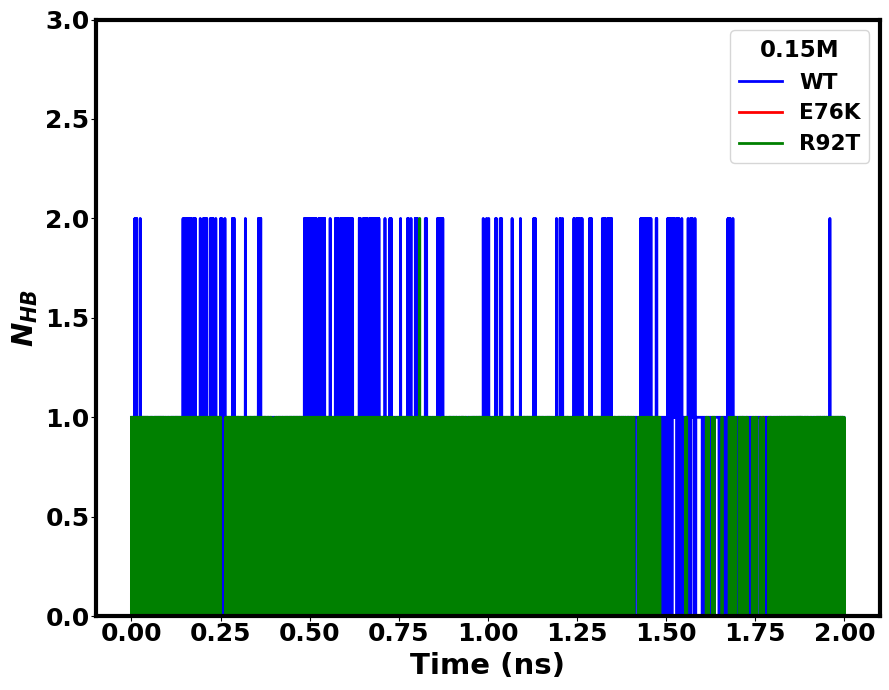

In [32]:
#Plot Hydrogen bonds number
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(9, 7))
#plt.style.use('seaborn-poster')
plt.plot(hbonds1.frames/5000, hbonds1.count_by_time(), lw=2, color='blue', label='WT')
plt.plot(hbonds3.frames/5000, hbonds3.count_by_time(), lw=2, color='r', label='E76K')
plt.plot(hbonds5.frames/5000, hbonds5.count_by_time(), lw=2, color='green', label='R92T')
# plt.title("Number of Hydrogen Bonds over Time", weight="bold")
plt.xlabel("Time (ns)",fontsize = 21.0, fontweight="bold")
plt.ylabel(r"$N_{HB}$", fontsize = 21.0, fontweight="bold")
plt.ylim([0, 3])
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.tick_params(labelsize=18, pad=1)
plt.tight_layout()
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
plt.legend(loc='upper right', title='0.15M', fontsize=15.5, title_fontsize=16.5)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.show()

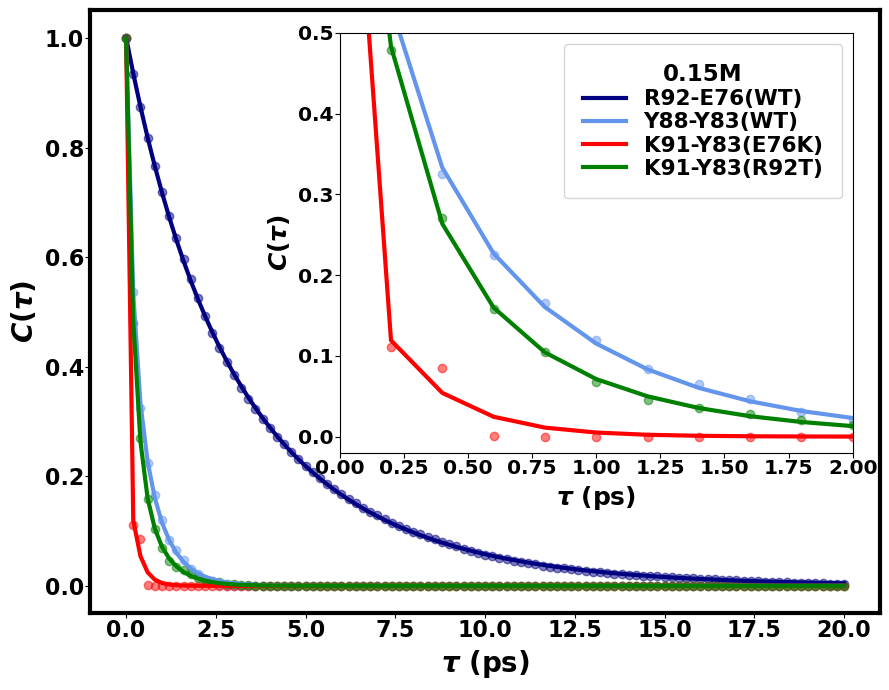

In [33]:
# Plot the lifetimes
fig, ax=plt.subplots(figsize=(9, 7))
colors1= ['navy', 'cornflowerblue', 'blue', 'green', 'seagreen', 'lawngreen']
label=['R92-E76(WT)', 'Y88-Y83(WT)','R92-R79(WT)', 'K91-Y83(R92T)', 'K91-Y83(R92T)', 'K91-Y83(R92T)']
#Raw-data
i=0   
for hbl in Ind[0:2]:
    plt.scatter(tau_times, hbl, color=colors1[i], alpha=0.5) #label=label[i], 
    i=i+1

plt.scatter(tau_times3, hbond3_lifetime, color='red', alpha=0.5) #label='K91-Y83(E76K)',

i=0
for hbl in Ind5[1:2]:
    plt.scatter(tau_times5, hbl, color=colors1[i+3], alpha=0.5) #label=label[i+3],
    i=i+1
    
#Curve fit
i=0
for hbl in opti_WT[0:2]:
    plt.plot(tau_times, hbl, label=label[i], lw=3, color=colors1[i])
    i=i+1
plt.plot(tau_times3, mody_E76K, label='K91-Y83(E76K)', lw=3, color='red')

i=0
for hbl in opti_R92T[1:2]:
    plt.plot(tau_times5, hbl, label=label[i+3], lw=3, color=colors1[i+3])
    i=i+1

plt.tick_params(labelsize=16, pad=1)
plt.xlabel(r"$\tau\ \rm (ps)$",fontsize = 20.0, fontweight="bold")
plt.ylabel(r"$C(\tau)$",fontsize = 20.0, fontweight="bold")
plt.rcParams["font.weight"] = "bold"
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
plt.rcParams["axes.labelweight"] = "bold"
plt.tight_layout()

axIns=fig.add_axes([0.383, 0.346, 0.570, 0.60])
i=0   
for hbl in Ind[0:2]:
    axIns.scatter(tau_times, hbl, color=colors1[i], alpha=0.5) #color=colors1[i],
    i=i+1

axIns.scatter(tau_times3, hbond3_lifetime, color='red', alpha=0.5) #label='K91-Y83(E76K)',

i=0
for hbl in Ind5[1:2]:
    axIns.scatter(tau_times5, hbl, color=colors1[i+3], alpha=0.5) #label=label[i+3],
    i=i+1
    
#Curve fit
i=0
for hbl in opti_WT[0:2]:
    axIns.plot(tau_times, hbl, label=label[i], lw=3, color=colors1[i])
    i=i+1
axIns.plot(tau_times3, mody_E76K, label='K91-Y83(E76K)', lw=3, color='red')

i=0
for hbl in opti_R92T[1:2]:
    axIns.plot(tau_times5, hbl, label=label[i+3], lw=3, color=colors1[i+3])
    i=i+1
axIns.set_ylim([-0.02, 0.5])
axIns.set_xlim([0, 2])
axIns.set_xlabel(r"$\tau\ \rm (ps)$",fontsize = 18.0, fontweight="bold")
axIns.set_ylabel(r"$C(\tau)$",fontsize = 18.0, fontweight="bold")
axIns.tick_params(labelsize=14.5, pad=1)
plt.legend(ncol=1, loc='upper right', fontsize=15.5, title='0.15M', title_fontsize=16.5, borderpad=0.9,labelspacing=0.15)
plt.show()

### Hydrogen Bond Analysis at 2.4 M

In [34]:
## NUMBER OF INTER-HELICAL HYDROGEN BONDS BETWEEN H2B-α2 AND H4α3 for Wild-type (WT)##

# top2= '/home/augustine/Nucleosome_system/1kx5/1kx5_2.4M/lifetime_1kx5_24M/1kx5-2M-OPC-trial3.prmtop'
# traj2='/home/augustine/Nucleosome_system/1kx5/1kx5_2.4M/lifetime_1kx5_24M/life_1kx5_24M.xtc'
# u2 = mda.Universe(top2, traj2) #1kx5_2.4M

top2= '/home/augustine/Nucleosome_system/1kx5/1kx5_2.4M/lifetime_1kx5_24M/lifetime_1kx5_24M.prmtop'
traj2='/home/augustine/Nucleosome_system/1kx5/1kx5_2.4M/lifetime_1kx5_24M/WT_24M.xtc'
u2 = mda.Universe(top2, traj2) #1kx5_2.4M

top4='/home/augustine/Nucleosome_system/E76K/E76K_24M/lifetime_E76K_24M_6us/1kx5-2M-E76K-OPC.prmtop'
traj4='/home/augustine/Nucleosome_system/E76K/E76K_24M/lifetime_E76K_24M_6us/life_E76K_24M.xtc'
u4 = mda.Universe(top4, traj4)  #E76K_2.4M

# top6='/home/augustine/Nucleosome_system/R92T/R92T_1/R92T_2.4M/R92T_24M_OPC.prmtop'
# traj6='/home/augustine/Nucleosome_system/R92T/R92T_1/R92T_2.4M/lifetime_R92T_24M/life_R92T_24M.xtc'
# u6 = mda.Universe(top6, traj6) #R92T_2.4M

top6='/home/augustine/Nucleosome_system/R92T/R92T_1/R92T_2.4M/lifetime_R92T_24M/lifetime_R92T_24M.prmtop'
traj6='/home/augustine/Nucleosome_system/R92T/R92T_1/R92T_2.4M/lifetime_R92T_24M/lifetime_R92T_24M.xtc'
u6 = mda.Universe(top6, traj6) #R92T_2.4M


#### Wild-Type at 2.4 M

In [36]:
## NUMBER OF INTER-HELICAL HYDROGEN BONDS BETWEEN H2B-α2 AND H4α3 for Wild-type (WT)##

from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds2 = HBA(
    universe=u2, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 511-522', 'resid 711-740']
  )
hydrogens_sel2 = hbonds2.guess_hydrogens("resid 511-522 711-740")
acceptors_sel2 = hbonds2.guess_acceptors("resid 511-522 711-740")

hbonds2.hydrogens_sel = f"({hydrogens_sel2})"
hbonds2.acceptors_sel = f"({acceptors_sel2})"

hbonds2.run()
hbonds2.results

{'hbonds': array([[1.08000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.93656076e+00, 1.42592556e+02],
       [1.13000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.93836542e+00, 1.35401992e+02],
       [3.66000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.80144940e+00, 1.39144985e+02],
       [3.67000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.94832255e+00, 1.37096470e+02],
       [3.73000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.72166301e+00, 1.49279032e+02],
       [3.74000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.87909363e+00, 1.36653126e+02],
       [3.84000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.95817362e+00, 1.53166470e+02],
       [4.89000000e+02, 1.29910000e+04, 1.29920000e+04, 1.65500000e+04,
        2.71161286e+00, 1.56772752e+02],
       [8.48000000e+02, 1.30440000e+04, 1.30450000e+04, 1.65430000e+04,
        2.965

In [38]:
## Time autocorrelation of hydrogen bonds, Lifetime Calculations for all-bond
tau_max = 100
window_step = 1
dt=0.2
#Time-autocorrelation and lifetime
tau_frames, hbonds2_lifetime = hbonds2.lifetime(
    tau_max=tau_max,
    window_step=window_step)
tau_times2 = tau_frames * u2.trajectory.dt
# Approximate Curve fit
hbonds2_lifetime = np.array([1., 0.21267606, 10.51324360e-02, 9.51324360e-04, 6.51324360e-8, 1.51324360e-14, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

def model(tau_times2, A, tau1, B, tau2):
    return A * np.exp(-tau_times2/tau1) + B*np.exp(-tau_times2/tau2)
params, params_covariance = curve_fit(model, tau_times2, hbonds2_lifetime, p0=[1, 0.5, 1, 2])   
A_opt,tau1_opt,B_opt,tau2_opt = params
modx_WT_24M = np.linspace(tau_times2[0],tau_times2[-1], tau_max+1)
mody_WT_24M  =  A_opt * np.exp(-tau_times2 / tau1_opt) + B_opt * np.exp(-tau_times2 / tau2_opt)
Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
print(f"time_constant_1kx5_2.4M={Time_Constant:.3f}ps \n")
print(params)

#integral to get lifetime
T_1kx5= lambda tau_times2, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times2/tau1_opt) + B_opt*np.exp(-tau_times2/tau2_opt)
T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
print(f"lifetime_1kx5_2.4M={T[0]:.3f}ps, error={T[1]}ps \n")

#Errors
perr =np.sqrt(np.diag(params_covariance))
# print(perr)

modelPredictions = model(tau_times2, *params) 
absError = modelPredictions - hbonds2_lifetime

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(hbonds2_lifetime))

print('Parameters:', params)
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

time_constant_1kx5_2.4M=0.121ps 

[0.40377117 0.00750007 0.59622883 0.198511  ]
lifetime_1kx5_2.4M=0.121ps, error=4.13115867524645e-11ps 

Parameters: [0.40377117 0.00750007 0.59622883 0.198511  ]
RMSE: 0.003980742008134857
R-squared: 0.9984652521870067


In [40]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_WT_24M = hbonds2.count_by_ids()
for donor, hydrogen, acceptor, count in counts_WT_24M[:6]:
    d, h, a = u2.atoms[donor-1], u2.atoms[hydrogen-1], u2.atoms[acceptor-1]
    print(f"{d.resname}-{d.resid}-{d.name}\t{h.name}\t{a.resname}-{a.resid}-{a.name}\tcount={count}")

TYR-517-OH	HH	TYR-739-O	count=49
LYS-520-NZ	HZ1	TYR-739-OH	count=22


In [42]:
## Analysis of Specific Hydrogen Bonds
tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond2_lifetimes = []
labels = [] # for plotting

for hbond in counts_WT_24M[:5]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds2 = HBA(
        universe=u2,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds2.run()

    # calculate lifetime
    taus, hbl, = tmp_hbonds2.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond2_lifetimes.append(hbl)
    # label for plotting
    donor, acceptor = u2.atoms[d_ix-1], u2.atoms[a_ix-1]
    label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels.append(label)
hbond2_lifetimes = np.array(hbond2_lifetimes)
labels = np.array(labels)

Indi_lifetime = pd.DataFrame(hbond2_lifetimes)
Indi_lifetime.to_csv("Indi_lifetime_WT_24M.csv")

In [43]:
## Lifetime of Specific Hydrogen Bonds
tau_times2 = np.linspace(0, 20, 101)
Indi = pd.read_csv('Indi_lifetime_WT_24M.csv')
Ind=Indi.iloc[0:, 1:].values
opti_WT= []

try:
    for i in Ind:
        def model(tau_times2, A, tau1, B, tau2):
            return A * np.exp(-tau_times2 / tau1) + B * np.exp(-tau_times2 / tau2)
        params, params_covariance = curve_fit(model, tau_times2, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_WT_24M = np.linspace(tau_times2[0], tau_times2[-1], tau_max+1)
        mody_WT_24M = A_opt * np.exp(-tau_times2 / tau1_opt) + B_opt * np.exp(-tau_times2 / tau2_opt)
        opti_WT.append(mody_WT_24M)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        print(f"time_constant_1kx5_0.15M={Time_Constant:.3f}ps \n")
        
        #integral to get lifetime
        T_1kx5= lambda tau_times2, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times2/tau1_opt) + B_opt*np.exp(-tau_times2/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
        print(f"lifetime_1kx5_24M={T[0]:.3f}ps, error={T[1]}ps \n")
except RuntimeError:
    print(opti_WT)

time_constant_1kx5_0.15M=0.090ps 

lifetime_1kx5_24M=0.090ps, error=1.4154146016042072e-10ps 

time_constant_1kx5_0.15M=0.033ps 

lifetime_1kx5_24M=0.033ps, error=4.622616146439276e-09ps 



#### H4E76K at 2.4 M

In [46]:
##NUMBER OF INTER-HELICAL HYDROGEN BONDS BETWEEN H2B-α2 AND H4α3 H2BE76K##
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds4 = HBA(
    universe=u4, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 511-522', 'resid 711-740']
  )
hydrogens_sel4 = hbonds4.guess_hydrogens("resid 511-522 711-740")
acceptors_sel4 = hbonds4.guess_acceptors("resid 511-522 711-740")

hbonds4.hydrogens_sel = f"({hydrogens_sel4})"
hbonds4.acceptors_sel = f"({acceptors_sel4})"

hbonds4.run()
hbonds4.results

{'hbonds': array([[8.34200000e+03, 1.30440000e+04, 1.30460000e+04, 1.65500000e+04,
        2.94314620e+00, 1.36919880e+02],
       [8.35800000e+03, 1.30440000e+04, 1.30460000e+04, 1.65500000e+04,
        2.93586168e+00, 1.38280851e+02],
       [8.36900000e+03, 1.30440000e+04, 1.30470000e+04, 1.65500000e+04,
        2.99948180e+00, 1.45735059e+02]])}

In [48]:
tau_max = 100
window_step = 1
dt=0.2
#Time-autocorrelation and lifetime
tau_frames, hbonds4_lifetime = hbonds4.lifetime(
    tau_max=tau_max,
    window_step=window_step)
tau_times4 = tau_frames * dt
hbonds4_lifetime = np.array([1.0, 0.12, 10.51324360e-02, 9.51324360e-04, 6.51324360e-8, 1.51324360e-14, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

def model(tau_times4, A, tau1, B, tau2):
    return A * np.exp(-tau_times4/tau1) + B*np.exp(-tau_times4/tau2)
params, params_covariance = curve_fit(model, tau_times4, hbonds4_lifetime, p0=[1, 0.5, 1, 1])   
A_opt,tau1_opt,B_opt,tau2_opt = params
modx_E76K_24M = np.linspace(tau_times4[0], tau_times4[-1], tau_max+1)
mody_E76K_24M =  model(modx_E76K_24M, A_opt,tau1_opt,B_opt,tau2_opt)
Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
print(f"time_constant_E76K_2.4M={Time_Constant:.3f}ps")
print(params)

#integral to get lifetime
T_1kx5= lambda tau_times4, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times4/tau1_opt) + B_opt*np.exp(-tau_times4/tau2_opt)
T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
print(f"lifetime_E76K_2.4M={T[0]:.3f}ps, error={T[1]}ps")

#Errors
perr =np.sqrt(np.diag(params_covariance))

modelPredictions = model(tau_times4, *params) 
absError = modelPredictions - hbonds4_lifetime

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(hbonds4_lifetime))

print('Parameters:', params)
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

time_constant_E76K_2.4M=0.077ps
[0.72560748 0.0035977  0.27439252 0.27173065]
lifetime_E76K_2.4M=0.077ps, error=3.9313266560875824e-10ps
Parameters: [0.72560748 0.0035977  0.27439252 0.27173065]
RMSE: 0.005480142941160152
R-squared: 0.9970052239951571


In [49]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_E76K_24M = hbonds4.count_by_ids()
for donor, hydrogen, acceptor, count in counts_E76K_24M[:6]:
    d, h, a = u4.atoms[donor-1], u4.atoms[hydrogen-1], u4.atoms[acceptor-1]
    print(f"{d.resname}-{d.resid}-{d.name}\t{h.name}\t{a.resname}-{a.resid}-{a.name}\tcount={count}")

LYS-520-NZ	HZ2	TYR-739-OH	count=2
LYS-520-NZ	HZ3	TYR-739-OH	count=1


In [51]:
tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond4_lifetimes = []
labels = [] # for plotting

for hbond in counts_E76K_24M[:5]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds4 = HBA(
        universe=u4,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds4.run()

    # calculate lifetime
    taus, hbl, = tmp_hbonds4.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond4_lifetimes.append(hbl)
    # label for plotting
    donor, acceptor = u4.atoms[d_ix-1], u4.atoms[a_ix-1]
    label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels.append(label)
hbond4_lifetimes = np.array(hbond4_lifetimes)
labels = np.array(labels)

Indi_lifetime = pd.DataFrame(hbond4_lifetimes)
Indi_lifetime.to_csv("Indi_lifetime_E76K_24M.csv")

In [52]:
tau_times4 = np.linspace(0, 20, 101)
Indi4 = pd.read_csv('Indi_lifetime_E76K_24M.csv')
Ind4=Indi4.iloc[0:, 1:].values
opti_E76K= []
#Ind=Ind[0]

try:
    for i in Ind4:
        # print(i)
        def model(tau_times4, A, tau1, B, tau2):
            return A * np.exp(-tau_times4 / tau1) + B * np.exp(-tau_times4 / tau2)
        params, params_covariance = curve_fit(model, tau_times4, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_E76K_24M  = np.linspace(tau_times4[0], tau_times4[-1], tau_max+1)
        mody_E76K_24M = A_opt * np.exp(-tau_times4 / tau1_opt) + B_opt * np.exp(-tau_times4 / tau2_opt)
        opti_E76K.append(mody_E76K_24M)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        print(f"time_constant_E76K_24M={Time_Constant:.3f}ps \n")
        
        #integral to get lifetime
        T_1kx5= lambda tau_times4, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times4/tau1_opt) + B_opt*np.exp(-tau_times4/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
        print(f"lifetime_E76K_24M={T[0]:.3f}ps, error={T[1]}ps \n")
except RuntimeError:
    print(opti_E76K)

time_constant_E76K_24M=0.006ps 

lifetime_E76K_24M=0.006ps, error=1.704867581564664e-09ps 

time_constant_E76K_24M=0.008ps 

lifetime_E76K_24M=0.008ps, error=4.329250453095836e-09ps 



#### H4R92T at 2.4 M

In [54]:
##NUMBER OF INTER-HELICAL HYDROGEN BONDS BETWEEN ALPHA 2 AND ALPHA 3##
##R92T_2.4M
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds6 = HBA(
    universe=u6, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 511-522', 'resid 711-740']
  )
hydrogens_sel6 = hbonds6.guess_hydrogens("resid 511-522 711-740")
acceptors_sel6 = hbonds6.guess_acceptors("resid 511-522 711-740")

hbonds6.hydrogens_sel = f"({hydrogens_sel6})"
hbonds6.acceptors_sel = f"({acceptors_sel6})"

hbonds6.run()
hbonds6.results

{'hbonds': array([[1.61900000e+03, 1.30440000e+04, 1.30450000e+04, 1.65330000e+04,
        2.95399931e+00, 1.47127660e+02]])}

In [55]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_R92T_24M = hbonds6.count_by_ids()
for donor, hydrogen, acceptor, count in counts_R92T_24M[:6]:
    d, h, a = u6.atoms[donor-1], u6.atoms[hydrogen-1], u6.atoms[acceptor-1]
    print(f"{d.resname}-{d.resid}-{d.name}\t{h.name}\t{a.resname}-{a.resid}-{a.name}\tcount={count}")

LYS-520-NZ	HZ1	TYR-739-OH	count=1


In [58]:
tau_max = 100
window_step = 1
dt=0.2
#Time-autocorrelation and lifetime
tau_frames, hbonds8_lifetime = hbonds6.lifetime(
    tau_max=tau_max,
    window_step=window_step)
tau_times8 = tau_frames * dt
hbonds8_lifetime = np.array([1.0, 0.0185, 9.51324360e-04, 9.51324360e-07, 6.51324360e-10, 1.51324360e-14, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#Time-autocorrelation and lifetime
def model(tau_times8, A, tau1, B, tau2):
    return A * np.exp(-tau_times8/tau1) + B*np.exp(-tau_times8/tau2)
params, params_covariance = curve_fit(model, tau_times8, hbonds8_lifetime, p0=[1, 0.5, 1, 2])   
A_opt,tau1_opt,B_opt,tau2_opt = params
x_model8 = np.linspace(min(tau_times8), max(tau_times8), tau_max+1)
y_model8 =  model(x_model8, A_opt,tau1_opt,B_opt,tau2_opt)
Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
print(f"time_constant_R92&_24M={Time_Constant:.3f}ps")
print(params)

#integral to get lifetime
T_1kx5= lambda tau_times8, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times8/tau1_opt) + B_opt*np.exp(-tau_times8/tau2_opt)
#f = lambda x, a, b: a*x**2 + b*x
T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
print(f"lifetime_R92T_24M={T[0]:.3f}ps, error={T[1]}ps \n")

#Errors
perr =np.sqrt(np.diag(params_covariance))

modelPredictions = model(tau_times8, *params) 
absError = modelPredictions - hbonds8_lifetime

SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(hbonds8_lifetime))
print('\n Parameters:', params)
print('\n RMSE:', RMSE)
print('\n R-squared:', Rsquared)

time_constant_R92&_24M=0.029ps
[0.6383799  0.00732903 0.3616201  0.06727626]
lifetime_R92T_24M=0.029ps, error=6.385522233639905e-10ps 


 Parameters: [0.6383799  0.00732903 0.3616201  0.06727626]

 RMSE: 4.754524385295882e-06

 R-squared: 0.999999997714452


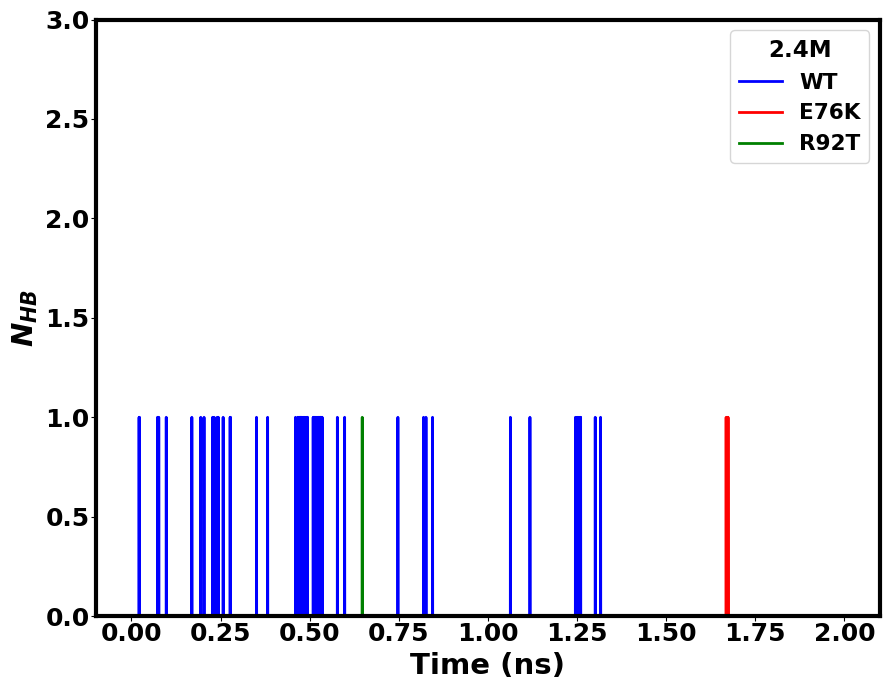

In [59]:
#Plot Hydrogen bonds number
import matplotlib.pyplot as plt
fig, ax=plt.subplots(figsize=(9, 7))
#plt.style.use('seaborn-poster')
plt.plot(hbonds2.frames/5000, hbonds2.count_by_time(), lw=2, color='blue', label='WT')
plt.plot(hbonds4.frames/5000, hbonds4.count_by_time(), lw=2, color='r', label='E76K')
plt.plot(hbonds6.frames/2500, hbonds6.count_by_time(), lw=2, color='green', label='R92T')
# plt.title("Number of Hydrogen Bonds over Time", weight="bold")
plt.xlabel("Time (ns)",fontsize = 21.0, fontweight="bold")
plt.ylabel(r"$N_{HB}$", fontsize = 21.0, fontweight="bold")
plt.ylim([0, 3])
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.tick_params(labelsize=18, pad=1)
plt.tight_layout()
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
plt.legend(loc='upper right', title='2.4M', fontsize=15.5, title_fontsize=16.5)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.show()

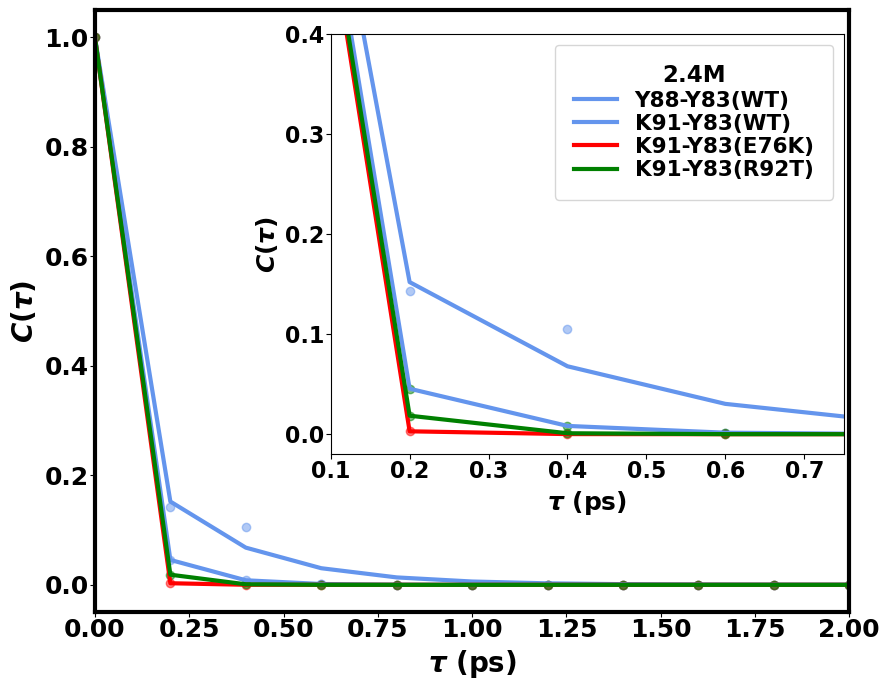

In [61]:
# Plot the lifetimes
fig, ax=plt.subplots(figsize=(9, 7))
colors1= ['cornflowerblue', 'cornflowerblue', 'green', 'red', 'lawngreen']
label=['Y88-Y83(WT)','K91-Y83(WT)', 'K91-Y83(E76K)', 'K91-Y83(R92T)']
#Raw-data
i=0   
for hbl in Ind[0:2]:
    plt.scatter(tau_times2, hbl, color=colors1[i], alpha=0.5)# label=label[i],
    i=i+1

i=0
for hbl in Ind4[0:1]:
    plt.scatter(tau_times4, hbl,  color=colors1[i+3], alpha=0.5)#label=label[i+2],
    i=i+1

plt.scatter(tau_times8, hbonds8_lifetime, color='green', alpha=0.5) # label=label[3],
    
# Curve fit
i=0   
for hbl in opti_WT[0:2]:
    plt.plot(tau_times2, hbl, label=label[i], lw=3, color=colors1[i])
    i=i+1

i=0
for hbl in opti_E76K[0:1]:
    plt.plot(tau_times4, hbl, label=label[i+2], lw=3, color=colors1[i+3])
    i=i+1

plt.plot(x_model8, y_model8, label=label[3], lw=3, color='green')

plt.tick_params(labelsize=18, pad=1)
plt.xlabel(r"$\tau\ \rm (ps)$",fontsize = 20.0, fontweight="bold")
plt.ylabel(r"$C(\tau)$",fontsize = 20.0, fontweight="bold")
plt.rcParams["font.weight"] = "bold"
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

# plt.ylim([-5, 0])
plt.xlim([0, 2])
plt.rcParams["axes.labelweight"] = "bold"
plt.tight_layout()

axIns=fig.add_axes([0.373, 0.344, 0.570, 0.60])
for hbl in Ind[0:2]:
    axIns.scatter(tau_times2, hbl, color=colors1[i], alpha=0.5)# label=label[i],
    i=i+1

i=0
for hbl in Ind4[0:1]:
    axIns.scatter(tau_times4, hbl, color=colors1[i+3], alpha=0.5)# label=label[i+2],
    i=i+1

axIns.scatter(tau_times8, hbonds8_lifetime, color='green', alpha=0.5) #label=label[3],
    
# Curve fit
i=0   
for hbl in opti_WT[0:2]:
    axIns.plot(tau_times2, hbl, label=label[i], lw=3, color=colors1[i])
    i=i+1

i=0
for hbl in opti_E76K[0:1]:
    axIns.plot(tau_times4, hbl, label=label[i+2], lw=3, color=colors1[i+3])
    i=i+1

axIns.plot(x_model8, y_model8, label=label[3], lw=3, color='green')
axIns.set_ylim([-0.02, 0.4])
axIns.set_xlim([0.1, 0.75])
axIns.set_yticks([0,0.1,0.2,0.3,0.4])


axIns.set_xlabel(r"$\tau\ \rm (ps)$",fontsize = 18.0, fontweight="bold")
axIns.set_ylabel(r"$C(\tau)$",fontsize = 18.0, fontweight="bold")
axIns.tick_params(labelsize=16, pad=1)
plt.legend(ncol=1, loc='upper right', fontsize=15.5, title='2.4M', title_fontsize=16.5, borderpad=0.9,labelspacing=0.15)
plt.show()

## Hydrogen Bond Analysis at other helices including H2B-α2 AND H4α3 at the h4-H2B interface

### Hydrogen Bond Analysis at 0.15M

### Wild-Type at 0.15M

In [64]:
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds1 = HBA(
    universe=u1, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 295-531 782-1018', 'resid 532-781 1019-1268']
  )
hydrogens_sel1 = hbonds1.guess_hydrogens("resid 295-531 782-1018 532-781 1019-1268")
acceptors_sel1 = hbonds1.guess_acceptors("resid 295-531 782-1018 532-781 1019-1268")

hbonds1.hydrogens_sel = f"({hydrogens_sel1})"
hbonds1.acceptors_sel = f"({acceptors_sel1})"

hbonds1.run(verbose=True)

In [67]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_WT = hbonds1.count_by_ids()
for donor, hydrogen, acceptor, count in counts_WT[:15]:
    d, h, a = u1.atoms[donor-1], u1.atoms[hydrogen-1], u1.atoms[acceptor-1]

tau_max = 100  print(f"lifetime_1kx5_0.15M={T[0]:.3f}ps, error={T[1]}ps \n")
dt=0.2
window_step = 1
intermittency = 0

hbond1_lifetimes = []
labels = [] # for plotting

for hbond in counts_WT[:15]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds1 = HBA(
        universe=u1,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds1.run(verbose=True)

    # calculate lifetime
    taus, hbl, = tmp_hbonds1.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond1_lifetimes.append(hbl)
    # label for plotting
    donor, acceptor = u1.atoms[d_ix-1], u1.atoms[a_ix-1]
    label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels.append(label)
hbond1_lifetimes = np.array(hbond1_lifetimes)
labels = np.array(labels)

Indi_lifetime = pd.DataFrame(hbond1_lifetimes)
Indi_lifetime.to_csv("Indi_all_lifetime_WT_015M.csv")

In [72]:
tau_times = np.linspace(0, 20, 101)
Indi = pd.read_csv('Indi_all_lifetime_WT_015M.csv')
Ind=Indi.iloc[0:, 1:].values
opti_WT= []
#Ind=Ind[0]

try:
    for i in Ind:
        def model(tau_times, A, tau1, B, tau2):
            return A * np.exp(-tau_times / tau1) + B * np.exp(-tau_times / tau2)
        params, params_covariance = curve_fit(model, tau_times, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx = np.linspace(tau_times[0], tau_times[-1], tau_max+1)
        mody = A_opt * np.exp(-tau_times / tau1_opt) + B_opt * np.exp(-tau_times / tau2_opt)
        opti_WT.append(mody)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        
        #integral to get lifetime
        T_1kx5= lambda tau_times1, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times1/tau1_opt) + B_opt*np.exp(-tau_times1/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
except RuntimeError:
    lifetime = 0

### H2BE76K at 0.15M

In [65]:
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds3 = HBA(
    universe=u3, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 295-531 782-1018', 'resid 532-781 1019-1268']
  )
hydrogens_sel3 = hbonds3.guess_hydrogens("resid 295-531 782-1018 532-781 1019-1268")
acceptors_sel3 = hbonds3.guess_acceptors("resid 295-531 782-1018 532-781 1019-1268")

hbonds3.hydrogens_sel = f"({hydrogens_sel3})"
hbonds3.acceptors_sel = f"({acceptors_sel3})"

hbonds3.run()

In [73]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_E76K = hbonds3.count_by_ids()
for donor, hydrogen, acceptor, count in counts_E76K[:15]:
    d, h, a = u3.atoms[donor-1], u3.atoms[hydrogen-1], u3.atoms[acceptor-1]
tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond3_lifetimes = []
labels3 = [] # for plotting

for hbond in counts_E76K[:15]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds3 = HBA(
        universe=u3,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds3.run(verbose=True)

    # calculate lifetime
    taus, hbl3, = tmp_hbonds3.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond3_lifetimes.append(hbl3)
    # label for plotting
    donor, acceptor = u3.atoms[d_ix-1], u3.atoms[a_ix-1]
    label3 = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels3.append(label3)
hbond3_lifetimes = np.array(hbond3_lifetimes)
labels3 = np.array(labels3)

Indi_lifetime = pd.DataFrame(hbond3_lifetimes)
Indi_lifetime.to_csv("Indi_all_lifetime_E76K_015M.csv")

In [74]:
tau_times3 = np.linspace(0, 20, 101)
Indi3 = pd.read_csv('Indi_all_lifetime_E76K_015M.csv')
Ind3=Indi3.iloc[0:, 1:].values
opti_E76K= []
#Ind=Ind[0]

try:
    for i in Ind3:
        def model(tau_times3, A, tau1, B, tau2):
            return A * np.exp(-tau_times3 / tau1) + B * np.exp(-tau_times3 / tau2)
        params, params_covariance = curve_fit(model, tau_times3, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_E76K = np.linspace(tau_times3[0], tau_times3[-1], tau_max+1)
        mody_E76K = A_opt * np.exp(-tau_times3 / tau1_opt) + B_opt * np.exp(-tau_times3 / tau2_opt)
        opti_E76K.append(mody_E76K)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        
        #integral to get lifetime
        T_1kx5= lambda tau_times3, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times3/tau1_opt) + B_opt*np.exp(-tau_times3/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
except RuntimeError:
    lifetime = 0

#### H4R92T at 0.15M

In [75]:
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds5 = HBA(
    universe=u5, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 295-531 782-1018', 'resid 532-781 1019-1268']
  )
hydrogens_sel5 = hbonds5.guess_hydrogens("resid 295-531 782-1018 532-781 1019-1268")
acceptors_sel5 = hbonds5.guess_acceptors("resid 295-531 782-1018 532-781 1019-1268")

hbonds5.hydrogens_sel = f"({hydrogens_sel5})"
hbonds5.acceptors_sel = f"({acceptors_sel5})"

hbonds5.run()

In [76]:
counts_R92T = hbonds5.count_by_ids()
for donor, hydrogen, acceptor, count in counts_R92T[:15]:
    d, h, a = u5.atoms[donor-1], u5.atoms[hydrogen-1], u5.atoms[acceptor-1]

tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond5_lifetimes = []
labels5 = [] # for plotting

for hbond in counts_R92T[:15]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds5 = HBA(
        universe=u5,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds5.run(verbose=True)

    # calculate lifetime
    taus, hbl5, = tmp_hbonds5.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond5_lifetimes.append(hbl5)
    # label for plotting
    donor, acceptor = u5.atoms[d_ix-1], u5.atoms[a_ix-1]
    label5 = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels5.append(label5)
hbond5_lifetimes = np.array(hbond5_lifetimes)
labels5 = np.array(labels5)

Indi_lifetime = pd.DataFrame(hbond5_lifetimes)
Indi_lifetime.to_csv("Indi_all_lifetime_R92T_015M.csv")

In [77]:
tau_times5 = np.linspace(0, 20, 101)
Indi5 = pd.read_csv('Indi_all_lifetime_R92T_015M.csv')
Ind5=Indi5.iloc[0:, 1:].values
opti_R92T= []
#Ind=Ind[0]

try:
    for i in Ind5:
        def model(tau_times5, A, tau1, B, tau2):
            return A * np.exp(-tau_times5 / tau1) + B * np.exp(-tau_times5 / tau2)
        params, params_covariance = curve_fit(model, tau_times5, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_R92T = np.linspace(tau_times5[0], tau_times5[-1], tau_max+1)
        mody_R92T = A_opt * np.exp(-tau_times5 / tau1_opt) + B_opt * np.exp(-tau_times5 / tau2_opt)
        opti_R92T.append(mody_R92T)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        
        #integral to get lifetime
        T_1kx5= lambda tau_times5, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times5/tau1_opt) + B_opt*np.exp(-tau_times5/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
except RuntimeError:
    lifetime = 0

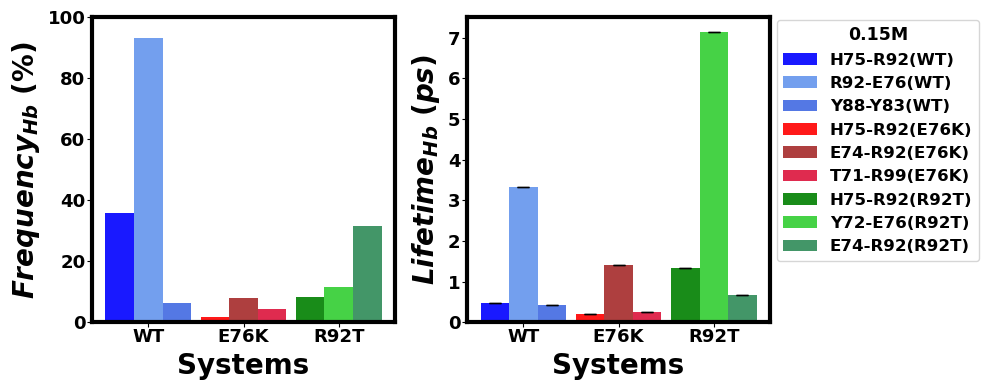

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
f = plt.figure(figsize=(10,4))
# fig, ax=plt.subplots(figsize=(6, 4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
Nucleosome = 3 
Ind = np.arange(Nucleosome) 
width = 0.3
systems = ['WT','E76K','R92T']
b1=[3584/100,154/100,812/100]
b1a = [0.467,0.211,1.327]
b1_err=[1.6090810684401835e-09, 3.18071096780591e-10,2.3816319373434273e-09]
bar1 = ax.bar(Ind, b1, width, color = ['blue', 'red','green'], align='center', alpha=0.9, ecolor='black',)
bar1 = ax2.bar(Ind, b1a, width, yerr=b1_err, color = ['blue', 'red','green'], align='center', alpha=0.9, ecolor='black', capsize=4)

b2=[9317/100,790/100,1155/100]
b2a = [3.330,1.416,7.152]
b2_err=[1.0389561020452217e-10, 1.1032003215683996e-11, 5.242960272353865e-09]
bar2 = ax.bar(Ind+width, b2, width, color = ['Cornflowerblue', 'brown','limegreen'], align='center', alpha=0.9, ecolor='black',)
bar2 = ax2.bar(Ind+width, b2a, width, yerr=b2_err, color = ['Cornflowerblue', 'brown','limegreen'], align='center', alpha=0.9, ecolor='black', capsize=4)

b3=[618/100,430/100,3158/100]
b3a = [0.422,0.240,0.659]
b3_err=[1.6119763224217088e-09, 4.1366128133239225e-11, 4.091739037492736e-10]
bar3 = ax.bar(Ind+2*width, b3, width, color = ['royalblue', 'crimson','seagreen'], align='center', alpha=0.9, ecolor='black',)
bar3 = ax2.bar(Ind+2*width, b3a, width, yerr=b3_err, color = ['royalblue', 'crimson','seagreen'], align='center', alpha=0.9, ecolor='black', capsize=4)

ax.set_xticks(Ind+width, systems)
ax2.set_xticks(Ind+width, systems)
ax.set_xlabel("Systems",fontsize = 20.0, fontweight="bold")
ax2.set_xlabel("Systems",fontsize = 20.0, fontweight="bold")
ax.set_ylabel(r"$Frequency_{Hb}\ (\%)$", fontsize = 20.0, fontweight="bold")
ax2.set_ylabel(r"$Lifetime_{Hb}\ (ps)$", fontsize = 20.0, fontweight="bold")
ax.set_ylim([0,100])
plt.legend([bar1[0], bar2[0], bar3[0],bar1[1], bar2[1], bar3[1], bar1[2], bar2[2], bar3[2]], ['H75-R92(WT)', 'R92-E76(WT)', 'Y88-Y83(WT)', 'H75-R92(E76K)', 'E74-R92(E76K)', 'T71-R99(E76K)', 'H75-R92(R92T)', 'Y72-E76(R92T)', 'E74-R92(R92T)'], 
           ncol=1, loc=(1.02,0.2), fontsize=12, title='0.15M', title_fontsize=12.5)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax.yaxis.set_tick_params(labelsize=13, pad=1,)
ax.xaxis.set_tick_params(labelsize=13, pad=1,)
ax2.xaxis.set_tick_params(labelsize=13, pad=1,)
ax2.yaxis.set_tick_params(labelsize=13, pad=1,)
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
ax2.spines["top"].set_linewidth(3)
ax2.spines["left"].set_linewidth(3)
ax2.spines["right"].set_linewidth(3)
ax2.spines["bottom"].set_linewidth(3)
plt.tight_layout()
plt.show()

## Hydrogen Bond Analysis at 2.4 M

### Wild-Type at 2.4 M

In [78]:
hbonds2 = HBA(
    universe=u2, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 430-531', 'resid 660-781']
  )
hydrogens_sel2 = hbonds2.guess_hydrogens("resid 430-531 660-781")
acceptors_sel2 = hbonds2.guess_acceptors("resid 430-531 660-781")

hbonds2.hydrogens_sel = f"({hydrogens_sel2})"
hbonds2.acceptors_sel = f"({acceptors_sel2})"

hbonds2.run()

In [79]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_WT_24M = hbonds2.count_by_ids()
for donor, hydrogen, acceptor, count in counts_WT_24M[:15]:
    d, h, a = u2.atoms[donor-1], u2.atoms[hydrogen-1], u2.atoms[acceptor-1]

tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond2_lifetimes = []
labels = [] # for plotting

for hbond in counts_WT_24M[:15]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds2 = HBA(
        universe=u2,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds2.run(verbose=True)

    # calculate lifetime
    taus, hbl, = tmp_hbonds2.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond2_lifetimes.append(hbl)
    # label for plotting
    donor, acceptor = u2.atoms[d_ix-1], u2.atoms[a_ix-1]
    label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels.append(label)
hbond2_lifetimes = np.array(hbond2_lifetimes)
labels = np.array(labels)

Indi_lifetime = pd.DataFrame(hbond2_lifetimes)
Indi_lifetime.to_csv("Indi_all_lifetime_WT_24M.csv")

In [80]:
tau_times2 = np.linspace(0, 20, 101)
Indi = pd.read_csv('Indi_lifetime_WT_24M.csv')
Ind=Indi.iloc[0:, 1:].values
opti_WT= []

try:
    for i in Ind:
        
        def model(tau_times2, A, tau1, B, tau2):
            return A * np.exp(-tau_times2 / tau1) + B * np.exp(-tau_times2 / tau2)
        params, params_covariance = curve_fit(model, tau_times2, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_WT_24M = np.linspace(tau_times2[0], tau_times2[-1], tau_max+1)
        mody_WT_24M = A_opt * np.exp(-tau_times2 / tau1_opt) + B_opt * np.exp(-tau_times2 / tau2_opt)
        opti_WT.append(mody_WT_24M)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        
        #integral to get lifetime
        T_1kx5= lambda tau_times2, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times2/tau1_opt) + B_opt*np.exp(-tau_times2/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
except RuntimeError:
    lifetime = 0

#### H2BE76K at 2.4 M

In [82]:
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds4 = HBA(
    universe=u4, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 430-531', 'resid 660-781']
  )
hydrogens_sel4 = hbonds4.guess_hydrogens("resid 430-531 660-781")
acceptors_sel4 = hbonds4.guess_acceptors("resid 430-531 660-781")

hbonds4.hydrogens_sel = f"({hydrogens_sel4})"
hbonds4.acceptors_sel = f"({acceptors_sel4})"

hbonds4.run()

In [83]:
# Print donor, hydrogen, acceptor and count info for these hbonds
counts_E76K_24M = hbonds4.count_by_ids()
for donor, hydrogen, acceptor, count in counts_E76K_24M[:15]:
    d, h, a = u4.atoms[donor-1], u4.atoms[hydrogen-1], u4.atoms[acceptor-1]

tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond4_lifetimes = []
labels = [] # for plotting

for hbond in counts_E76K_24M[:15]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds4 = HBA(
        universe=u4,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds4.run(verbose=True)

    # calculate lifetime
    taus, hbl, = tmp_hbonds4.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond4_lifetimes.append(hbl)
    # label for plotting
    donor, acceptor = u4.atoms[d_ix-1], u4.atoms[a_ix-1]
    label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels.append(label)
hbond4_lifetimes = np.array(hbond4_lifetimes)
labels = np.array(labels)

Indi_lifetime = pd.DataFrame(hbond4_lifetimes)
Indi_lifetime.to_csv("Indi_all_lifetime_E76K_24M.csv")

In [84]:
tau_times4 = np.linspace(0, 20, 101)
Indi4 = pd.read_csv('Indi_all_lifetime_E76K_24M.csv')
Ind4=Indi4.iloc[0:, 1:].values
opti_E76K= []
#Ind=Ind[0]

try:
    for i in Ind4:
        def model(tau_times4, A, tau1, B, tau2):
            return A * np.exp(-tau_times4 / tau1) + B * np.exp(-tau_times4 / tau2)
        params, params_covariance = curve_fit(model, tau_times4, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_E76K_24M  = np.linspace(tau_times4[0], tau_times4[-1], tau_max+1)
        mody_E76K_24M = A_opt * np.exp(-tau_times4 / tau1_opt) + B_opt * np.exp(-tau_times4 / tau2_opt)
        opti_E76K.append(mody_E76K_24M)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        
        #integral to get lifetime
        T_1kx5= lambda tau_times4, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times4/tau1_opt) + B_opt*np.exp(-tau_times4/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
except RuntimeError:
    lifetime=0

#### H4R92T at 2.4 M

In [85]:
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
hbonds6 = HBA(
    universe=u6, 
    update_selections=False,
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=135,
    between=['resid 430-531', 'resid 660-781']
  )
hydrogens_sel6 = hbonds6.guess_hydrogens("resid 430-531 660-781")
acceptors_sel6 = hbonds6.guess_acceptors("resid 430-531 660-781")

hbonds6.hydrogens_sel = f"({hydrogens_sel6})"
hbonds6.acceptors_sel = f"({acceptors_sel6})"

hbonds6.run()

In [86]:
counts_R92T_24M = hbonds6.count_by_ids()
for donor, hydrogen, acceptor, count in counts_R92T_24M[:15]:
    d, h, a = u6.atoms[donor-1], u6.atoms[hydrogen-1], u6.atoms[acceptor-1]

tau_max = 100
dt=0.2
window_step = 1
intermittency = 0

hbond6_lifetimes = []
labels = [] # for plotting

for hbond in counts_R92T_24M[:15]:
    # find hbonds between specific atoms
    d_ix, h_ix, a_ix = hbond[:3]
    tmp_hbonds6 = HBA(
        universe=u6,
        d_a_cutoff=3.0,
        d_h_a_angle_cutoff=135,
        hydrogens_sel=f'index {h_ix-1}',
        acceptors_sel=f'index {a_ix-1}',
        update_selections=False
        )
    tmp_hbonds6.run(verbose=True)

    # calculate lifetime
    taus, hbl, = tmp_hbonds6.lifetime(
        tau_max=tau_max,
        window_step = window_step,
        intermittency=intermittency
        )
    hbond6_lifetimes.append(hbl)
    # label for plotting
    donor, acceptor = u6.atoms[d_ix-1], u6.atoms[a_ix-1]
    label = f"{donor.resname}:{donor.resid} to {acceptor.resname}:{acceptor.resid}"
    labels.append(label)
hbond6_lifetimes = np.array(hbond6_lifetimes)
labels = np.array(labels)

Indi_lifetime = pd.DataFrame(hbond6_lifetimes)
Indi_lifetime.to_csv("Indi_all_lifetime_R92T_24M.csv")

In [87]:
tau_times4 = np.linspace(0, 20, 101)
Indi4 = pd.read_csv('Indi_all_lifetime_R92T_24M.csv')
Ind4=Indi4.iloc[0:, 1:].values
opti_E76K= []
#Ind=Ind[0]
tau_max = 100
try:
    for i in Ind4:
        def model(tau_times4, A, tau1, B, tau2):
            return A * np.exp(-tau_times4 / tau1) + B * np.exp(-tau_times4 / tau2)
        params, params_covariance = curve_fit(model, tau_times4, i, [1, 0.5, 1, 2])
        A_opt,tau1_opt,B_opt,tau2_opt = params
        modx_E76K_24M  = np.linspace(tau_times4[0], tau_times4[-1], tau_max+1)
        mody_E76K_24M = A_opt * np.exp(-tau_times4 / tau1_opt) + B_opt * np.exp(-tau_times4 / tau2_opt)
        opti_E76K.append(mody_E76K_24M)
        Time_Constant = A_opt*tau1_opt + B_opt*tau2_opt
        
        #integral to get lifetime
        T_1kx5= lambda tau_times4, A_opt, tau1_opt,B_opt,tau2_opt: A_opt * np.exp(-tau_times4/tau1_opt) + B_opt*np.exp(-tau_times4/tau2_opt)
        #f = lambda x, a, b: a*x**2 + b*x
        T = integrate.quad(T_1kx5, 0, np.inf, args=(A_opt, tau1_opt,B_opt,tau2_opt))
except RuntimeError:
    lifetime=0

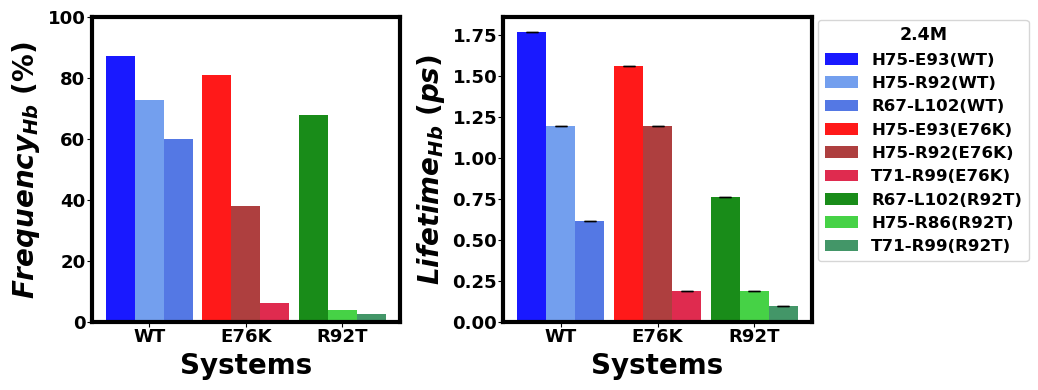

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
import math
f = plt.figure(figsize=(10.5,4))
# fig, ax=plt.subplots(figsize=(6, 4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
Nucleosome = 3 
Ind = np.arange(Nucleosome) 
width = 0.3
systems = ['WT','E76K','R92T']
b1=[8733/100,8112/100,3398/50]
b1a = [1.769,1.559,0.760]
b1_err=[4.483965214735433e-10, 4.101585320952241e-10,6.328445557959874e-11]
bar1 = ax.bar(Ind, b1, width, color = ['blue', 'red','green'], align='center', alpha=0.9, ecolor='black',)
bar1 = ax2.bar(Ind, b1a, width, yerr=b1_err, color = ['blue', 'red','green'], align='center', alpha=0.9, ecolor='black', capsize=4)

b2=[7271/100,3816/100,193/50]
b2a = [1.195,1.193,0.188]
b2_err=[1.8758502932102434e-09, 9.730626075494474e-10, 8.418831230738564e-09]
bar2 = ax.bar(Ind+width, b2, width, color = ['Cornflowerblue', 'brown','limegreen'], align='center', alpha=0.9, ecolor='black',)
bar2 = ax2.bar(Ind+width, b2a, width, yerr=b2_err, color = ['Cornflowerblue', 'brown','limegreen'], align='center', alpha=0.9, ecolor='black', capsize=4)

b3=[6017/100,635/100,127/50]
b3a = [0.616,0.192,0.101]
b3_err=[2.1343246203586143e-10, 2.736778430926419e-10, 9.538729733449442e-11]
bar3 = ax.bar(Ind+2*width, b3, width, color = ['royalblue', 'crimson','seagreen'], align='center', alpha=0.9, ecolor='black',)
bar3 = ax2.bar(Ind+2*width, b3a, width, yerr=b3_err, color = ['royalblue', 'crimson','seagreen'], align='center', alpha=0.9, ecolor='black', capsize=4)

ax.set_xticks(Ind+width, systems)
ax2.set_xticks(Ind+width, systems)
ax.set_xlabel("Systems",fontsize = 20.0, fontweight="bold")
ax2.set_xlabel("Systems",fontsize = 20.0, fontweight="bold")
ax.set_ylabel(r"$Frequency_{Hb}\ (\%)$", fontsize = 20.0, fontweight="bold")
ax2.set_ylabel(r"$Lifetime_{Hb}\ (ps)$", fontsize = 20.0, fontweight="bold")
ax.set_ylim([0, 100])
plt.legend([bar1[0], bar2[0], bar3[0],bar1[1], bar2[1], bar3[1], bar1[2], bar2[2], bar3[2]], ['H75-E93(WT)', 'H75-R92(WT)', 'R67-L102(WT)', 'H75-E93(E76K)', 'H75-R92(E76K)', 'T71-R99(E76K)', 'R67-L102(R92T)', 'H75-R86(R92T)', 'T71-R99(R92T)'],
           ncol=1, loc=(1.02,0.2), fontsize=12, title='2.4M', title_fontsize=12.5)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax.yaxis.set_tick_params(labelsize=13, pad=1,)
ax.xaxis.set_tick_params(labelsize=13, pad=1,)
ax2.xaxis.set_tick_params(labelsize=13, pad=1,)
ax2.yaxis.set_tick_params(labelsize=13, pad=1,)
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
ax2.spines["top"].set_linewidth(3)
ax2.spines["left"].set_linewidth(3)
ax2.spines["right"].set_linewidth(3)
ax2.spines["bottom"].set_linewidth(3)
plt.tight_layout()
plt.show()